In [ ]:
# This is actually faster than mounting Drive and loading data from there
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1eLTTvAdAAWyF0byuWhkspMlAoLWyUSGx' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1eLTTvAdAAWyF0byuWhkspMlAoLWyUSGx" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
from typing import Tuple
import matplotlib.pyplot as plt

In [13]:
BATCH_SIZE = 24
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [45]:
train_dir = './coffee-datasets/symptom/train'
val_dir = './coffee-datasets/symptom/val'
test_dir = './coffee-datasets/symptom/test'

In [46]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=180,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

train_data = train_gen.flow_from_directory(train_dir,
                                         color_mode="rgb",
                                         class_mode="categorical",
                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         batch_size=BATCH_SIZE)

val_gen = ImageDataGenerator(rescale=1./255)

val_data = val_gen.flow_from_directory(val_dir,
                                       color_mode="rgb",
                                       class_mode="categorical",
                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                       batch_size=BATCH_SIZE)

test_gen = ImageDataGenerator(rescale=1./255)

test_data = val_gen.flow_from_directory(test_dir,
                                        shuffle=False,
                                        color_mode="rgb",
                                        class_mode="categorical",
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        batch_size=1)

Found 1539 images belonging to 5 classes.
Found 335 images belonging to 5 classes.
Found 335 images belonging to 5 classes.


In [97]:
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
num_classes = train_data.num_classes

network = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    classes=num_classes,
)

for layer in network.layers:
    layer.trainable = True

In [98]:
model = tf.keras.Sequential([
    network,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=num_classes,
                          activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0005))
])

In [99]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [101]:
history = model.fit(train_data,
                    epochs=50,
                    validation_data=val_data)

Epoch 1/50
65/65 [==============================] - 28s 426ms/step - loss: 0.4516 - accuracy: 0.9110 - val_loss: 0.7514 - val_accuracy: 0.8985
Epoch 2/50
65/65 [==============================] - 28s 424ms/step - loss: 0.4134 - accuracy: 0.9168 - val_loss: 0.9219 - val_accuracy: 0.8746
Epoch 3/50
65/65 [==============================] - 27s 421ms/step - loss: 0.3159 - accuracy: 0.9363 - val_loss: 0.7008 - val_accuracy: 0.9045
Epoch 4/50
65/65 [==============================] - 28s 422ms/step - loss: 0.3663 - accuracy: 0.9227 - val_loss: 0.7835 - val_accuracy: 0.8746
Epoch 5/50
65/65 [==============================] - 27s 421ms/step - loss: 0.3626 - accuracy: 0.9298 - val_loss: 0.7747 - val_accuracy: 0.8925
Epoch 6/50
65/65 [==============================] - 28s 422ms/step - loss: 0.3349 - accuracy: 0.9363 - val_loss: 0.7578 - val_accuracy: 0.8985
Epoch 7/50
65/65 [==============================] - 27s 421ms/step - loss: 0.3412 - accuracy: 0.9357 - val_loss: 0.7080 - val_accuracy: 0.9194

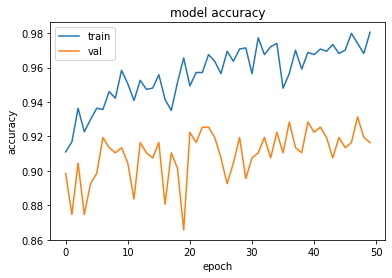

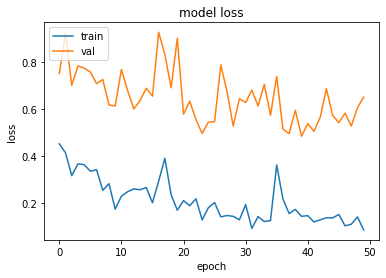

In [102]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [103]:
from sklearn.metrics import confusion_matrix
import numpy as np

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
matrix = confusion_matrix(test_data.classes, y_pred)

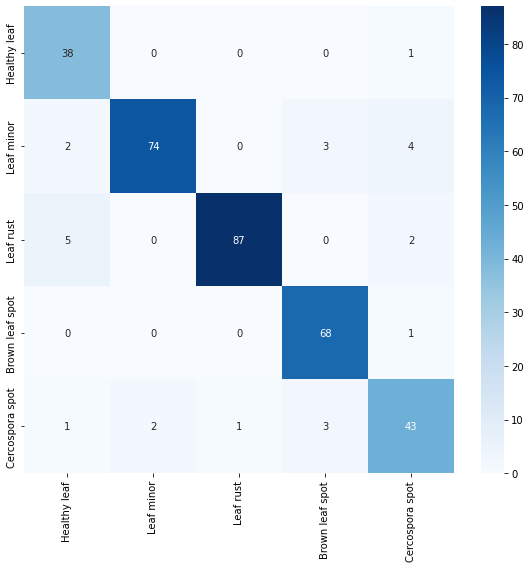

In [104]:
import matplotlib.pyplot as plt 
labels = ['Healthy leaf', 'Leaf minor', 'Leaf rust', 'Brown leaf spot', 'Cercospora spot']
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix,
            annot=True,
            cmap=plt.cm.Blues,
            xticklabels=labels,
            yticklabels=labels)
plt.tight_layout()
plt.show()

In [105]:
import shutil
model.save('./xception_model')
shutil.make_archive('xception_model', 'zip', 'xception_model')

import pickle

with open('./xception_hist', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: ./xception_model/assets


INFO:tensorflow:Assets written to: ./xception_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
